# ENCODER
Encodes the inputs to spikes.



In [9]:
#import modules

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import run_sft
import logging

In [10]:
#lava modules
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.resources import CPU
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.process.variable import Var

In [11]:
# Two Processes: one with an OutPort, one with an InPort
class P1(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (10,))
        bias = kwargs.pop("bias", 0)
        vth = kwargs.pop("vth", 10)
        
        self.shape = shape
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)
        self.w = Var(shape=shape, init=0)
        self.u = Var(shape=shape, init=0)
        self.v = Var(shape=shape, init=0)
        self.aux = Var(shape=shape, init=0)
        self.aux2 = Var(shape=shape, init=0)
        self.aux3 = Var(shape=shape, init=0)
        self.tspk = Var(shape=shape, init=0)
        self.k = Var(shape=shape, init=0)
        self.bias = Var(shape=shape, init=bias)
        self.vth = Var(shape=(1,), init=vth)
        self.s = Var(shape=(1,), init=0)
class P2(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get('shape', (10,))
        self.inp1 = InPort(shape=shape)
        self.aux3 = Var(shape=shape, init=0)



In [12]:
#PyProcModel implementing P1
@implements(proc=P1, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyLifModel1(PyLoihiProcessModel):
    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float, precision=24)
    w: np.ndarray = LavaPyType(np.ndarray, float)
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    aux: np.ndarray = LavaPyType(np.ndarray, float)
    aux2: np.ndarray = LavaPyType(np.ndarray, float)
    aux3: np.ndarray = LavaPyType(np.ndarray, float)
    bias: np.ndarray = LavaPyType(np.ndarray, float)
    tspk: np.ndarray = LavaPyType(np.ndarray, float)
    k: np.ndarray = LavaPyType(np.ndarray, float)
    vth: float = LavaPyType(float, float)
    s: np.ndarray = LavaPyType(np.ndarray, float)
    
    def run_spk(self):
        a_in_data=np.array([-10,10,5.5,0.3,3.5,-5,1.75,7.5,0.8,5])
        self.u=a_in_data
        if(self.time_step==1):
            m=(1-num_steps_per_input)/(np.max(self.u)-np.min(self.u))
            b=1-m*np.max(self.u)
            '''
            print("m : ",m)
            print("b : ",b)
            '''
            for index2 in range(len(self.u)):
                self.tspk[index2] =m*self.u[index2]+b
                self.k[index2] = (vth/self.tspk[index2])-self.u[index2]
            '''
            print(self.tspk[:])
            print(self.k[:])
            '''
        for index in range(len(self.v)):
            if (self.aux[index]<1):
                self.v[index] += self.u[index]+self.k[index]

        s_out = self.v+0.00001 >= self.vth
        self.aux[:]+=s_out
        self.aux2[s_out]=self.time_step
        self.v[s_out] = 0  # Reset voltage to 0
        self.s_out.send(self.aux)

        
        if(self.time_step==num_steps_per_input):
            print("\nInputs: {}".format(self.u))
            print("\nSpiking times: {}".format(self.aux2))
            plt.plot(self.aux2,a_in_data,'ro')
            plt.xlabel("Time (steps)")
            plt.ylabel("Inputs (voltage)")
            plt.title('Spiking time')
            plt.show()

#PyProcModel implementing P2
@implements(proc=P2, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyProcModelC(PyLoihiProcessModel):
    inp1: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    aux3: np.ndarray = LavaPyType(np.ndarray, float)

    def run_spk(self):
        in_data1 = self.inp1.recv()
        #if(self.time_step==num_steps_per_input):

            #print("\nReceived input data for P1: {}".format(in_data1))


        #spikes=sim_handler.initialize_snn().simulate(in_data1)


In [13]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps


Inputs: [-10.    10.     5.5    0.3    3.5   -5.     1.75   7.5    0.8    5.  ]

Spiking times: [100.   1.  24.  50.  34.  76.  42.  14.  47.  26.]


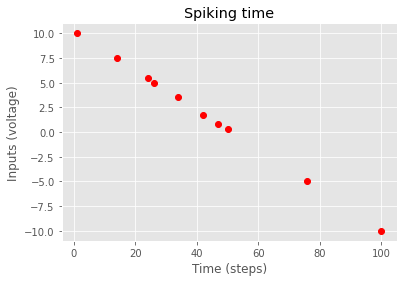

In [14]:

num_steps_per_input = 100
vth=10
step=1
lif = P1(shape=(10,), bias=step,num_steps=num_steps_per_input, threshold=vth)
lif2 = P2(shape=(10,))
run_cfg = Loihi1SimCfg()

lif.s_out.connect(lif2.inp1)


lif.run(condition=RunSteps(num_steps=num_steps_per_input), run_cfg=run_cfg)